# 2章 介入効果を測るための回帰分析

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../scripts/')

import numpy as np
import pandas as pd

import rdata
from rdd import rdd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from causalimpact import CausalImpact
from statsmodels.stats.weightstats import ttest_ind
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from propensity_score_matching import PropensityScoreMatching

In [2]:
# バイアスのあるデータの準備
email_data = pd.read_csv('http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')
male_df = email_data[email_data['segment'] != 'Womens E-Mail']
male_df['treatment'] = male_df['segment'].map(lambda x: 1 if x == 'Mens E-Mail' else 0)

treatment_data = male_df[male_df['treatment'] == 1]
control_data = male_df[male_df['treatment'] == 0]

treatment_biased = treatment_data.drop(treatment_data[~(
    (treatment_data['history'] > 300) |
    (treatment_data['recency'] < 6) |
    (treatment_data['recency'] == 'Multichannel')
)].sample(frac=0.5, random_state=1).index)

control_biased = control_data.drop(control_data[
    (control_data['history'] > 300) |
    (control_data['recency'] < 6) |
    (control_data['recency'] == 'Multichannel')
].sample(frac=0.5, random_state=1).index)

biased_data = pd.concat([treatment_biased, control_biased])
biased_data.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1


## 2.1 回帰分析の導入

### 2.1.5 メールマーケティングデータの分析（回帰編）

In [3]:
biased_reg = smf.ols(
    data=biased_data,
    formula='spend ~ treatment + history'
).fit()

In [4]:
biased_reg.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3718,0.149,2.496,0.013,0.080,0.664
treatment,0.8342,0.181,4.616,0.000,0.480,1.188
history,0.0013,0.000,3.669,0.000,0.001,0.002


## 2.2 回帰分析によるバイアス

### 2.2.1 共変量の追加による効果への作用

In [5]:
# RCTデータでの単回帰
rct_reg = smf.ols(data=male_df, formula='spend ~ treatment').fit()

In [6]:
# バイアスのあるデータでの単回帰
nonrct_reg = smf.ols(data=biased_data, formula='spend ~ treatment').fit()

In [7]:
rct_reg.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6528,0.103,6.356,0.000,0.451,0.854
treatment,0.7698,0.145,5.300,0.000,0.485,1.055


In [8]:
nonrct_reg.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6346,0.131,4.856,0.000,0.378,0.891
treatment,0.9261,0.179,5.174,0.000,0.575,1.277


In [9]:
# バイアスのあるデータでの重回帰
nonrct_mreg = smf.ols(
    'spend ~ treatment + history + channel + recency',
    data=biased_data
).fit()

In [10]:
nonrct_mreg.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2596,0.389,0.667,0.505,-0.503,1.023
channel[T.Phone],0.3854,0.315,1.225,0.221,-0.231,1.002
channel[T.Web],0.5524,0.314,1.759,0.079,-0.063,1.168
treatment,0.7642,0.185,4.129,0.000,0.401,1.127
history,0.0014,0.000,3.538,0.000,0.001,0.002
recency,-0.0498,0.027,-1.851,0.064,-0.102,0.003


### 2.2.3 OVBの確認

In [11]:
models = {
    'model_1' : smf.ols('spend ~ treatment + recency + channel', data=biased_data),
    'model_2': smf.ols('spend ~ treatment + recency + channel + history', data=biased_data),
    'model_3': smf.ols('history ~ treatment + recency + channel', data=biased_data)
}

results = {}
for name, model in models.items():
    results[name] = model.fit()

In [12]:
OVB = results['model_2'].params['history'] * results['model_3'].params['treatment']
coef_gap = results['model_1'].params['treatment'] - results['model_2'].params['treatment']

In [13]:
print('OVB: {:.5f}\ncoef_gap: {:.5f}'.format(OVB, coef_gap))

OVB: 0.04751
coef_gap: 0.04751


### 2.2.7 Post Treatment Bias

In [14]:
# visitと介入の相関
cor_visit_treatment = smf.ols(
    formula='treatment ~ visit + channel + recency + history', 
    data=biased_data
).fit()

In [15]:
cor_visit_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6697,0.011,60.144,0.000,0.648,0.692
channel[T.Phone],-0.0221,0.009,-2.334,0.020,-0.041,-0.004
channel[T.Web],-0.0247,0.009,-2.612,0.009,-0.043,-0.006
visit,0.1478,0.008,19.417,0.000,0.133,0.163
recency,-0.0300,0.001,-37.790,0.000,-0.032,-0.028
history,0.0001,1.17e-05,12.113,0.000,0.000,0.000


In [16]:
# visitを入れた回帰分析を実行
bad_control_reg = smf.ols(
    formula='spend ~ treatment + visit + channel + recency + history', 
    data=biased_data
).fit()

In [17]:
bad_control_reg.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.7260,0.385,-1.884,0.060,-1.481,0.029
channel[T.Phone],0.5023,0.310,1.619,0.106,-0.106,1.111
channel[T.Web],0.4331,0.310,1.398,0.162,-0.174,1.040
treatment,0.1682,0.184,0.916,0.359,-0.192,0.528
visit,7.5465,0.251,30.044,0.000,7.054,8.039
recency,0.0025,0.027,0.094,0.925,-0.050,0.055
history,0.0009,0.000,2.357,0.018,0.000,0.002


## 2.3 回帰分析を利用した探索的な効果検証

### 2.3.2 回帰分析の実行

In [18]:
# https://github.com/nekoumei/cibook-python/blob/master/notebook/ch2_voucher.ipynbより引用
# 予めhttps://github.com/itamarcaspi/experimentdatar/blob/master/data/vouchers.rdaからrdaファイルをダウンロードして/dataに配置しておく。
parsed = rdata.parser.parse_file('../data/vouchers.rda')
converted = rdata.conversion.convert(parsed)
vouchers = converted['vouchers']
vouchers.head()

,ID,BOG95SMP,BOG97SMP,JAM93SMP,SEX,AGE,AGE2,HSVISIT,SCYFNSH,INSCHL,...,REPT,NREPT,FINISH6,FINISH7,FINISH8,SEX_MISS,USNGSCH,HOURSUM,TAB3SMPL,WORKING3
0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,0.0,1.0,NaN,12.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,0.0,0.0,0.0,0.0,NaN,13.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1.0,0.0,0.0,0.0,14.0,12.0,0.0,8.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,4.0,1.0,0.0,0.0,1.0,14.0,12.0,0.0,8.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [19]:
formula_x_base = 'VOUCH0'
formula_x_covariate = '''
    SVY + HSVISIT + AGE + STRATA1 + STRATA2 + STRATA3 + 
    STRATA4 + STRATA5 + STRATA6 + STRATAMS + D1993 + D1995 + D1997 + 
    DMONTH1 + DMONTH2 + DMONTH3 + DMONTH4 + DMONTH5 + DMONTH6 + DMONTH7 + 
    DMONTH8 + DMONTH9 + DMONTH10 + DMONTH11 + DMONTH12 + SEX2
'''
formula_y = ["TOTSCYRS","INSCHL","PRSCH_C","USNGSCH","PRSCHA_1","FINISH6","FINISH7","FINISH8","REPT6",
             "REPT","NREPT", "MARRIED","HASCHILD","HOURSUM","WORKING3"]

In [20]:
regression_data = vouchers[(vouchers['TAB3SMPL'] == 1) & (vouchers['BOG95SMP'] == 1)]

In [21]:
def get_model_results(models, model_suffix='base'):
    columns = ['model_index', 'coef', 'std err', 't', 'P>|t|', '[0.025', '0.975]']
    results = pd.DataFrame(columns=columns)
    for i, v in models.items():
        result = pd.DataFrame(v.summary().tables[1].data[1:], columns=v.summary().tables[1].data[0])
        result['model_index'] = i + '_' + model_suffix
        results = results.append(result[result[''] == 'VOUCH0'][columns])
    return results.reset_index(drop=True)

In [22]:
# 共変量を含まない回帰
models = {}
for y in formula_y:
    model = smf.ols(formula='{} ~ {}'.format(y, formula_x_base), data=regression_data)
    models[y] = model.fit()

In [23]:
model_results = get_model_results(models)
model_results['coef'] = model_results['coef'].astype(np.float32)
model_results = model_results.dropna()
model_results

,model_index,coef,std err,t,P>|t|,[0.025,0.975]
0,TOTSCYRS_base,0.0581,0.052,1.110,0.267,-0.045,0.161
1,INSCHL_base,0.0186,0.022,0.860,0.390,-0.024,0.061
2,PRSCH_C_base,0.1600,0.028,5.655,0.000,0.104,0.216
3,USNGSCH_base,0.5089,0.023,22.107,0.000,0.464,0.554
4,PRSCHA_1_base,0.0629,0.017,3.731,0.000,0.030,0.096
5,FINISH6_base,0.0262,0.012,2.173,0.030,0.003,0.050
6,FINISH7_base,0.0402,0.020,2.009,0.045,0.001,0.079
7,FINISH8_base,0.1119,0.027,4.119,0.000,0.059,0.165
8,REPT6_base,-0.0657,0.024,-2.709,0.007,-0.113,-0.018
9,REPT_base,-0.0601,0.023,-2.581,0.010,-0.106,-0.014


In [24]:
# 共変量を含む回帰
models_with_cov = {}
for y in formula_y:
    model = smf.ols(formula='{} ~ {} + {}'.format(y, formula_x_base, formula_x_covariate), data=regression_data)
    models_with_cov[y] = model.fit()

In [25]:
models_with_cov_results = get_model_results(models_with_cov, 'covariate')
models_with_cov_results['coef'] = models_with_cov_results['coef'].astype(np.float32)
models_with_cov_results = models_with_cov_results.dropna()
models_with_cov_results

,model_index,coef,std err,t,P>|t|,[0.025,0.975]
0,TOTSCYRS_covariate,0.0337,0.051,0.661,0.509,-0.066,0.134
1,INSCHL_covariate,0.0069,0.020,0.340,0.734,-0.033,0.047
2,PRSCH_C_covariate,0.1533,0.028,5.520,0.000,0.099,0.208
3,USNGSCH_covariate,0.5042,0.023,22.007,0.000,0.459,0.549
4,PRSCHA_1_covariate,0.0574,0.017,3.385,0.001,0.024,0.091
5,FINISH6_covariate,0.0229,0.012,1.910,0.056,-0.001,0.047
6,FINISH7_covariate,0.0307,0.020,1.557,0.120,-0.008,0.070
7,FINISH8_covariate,0.1002,0.027,3.715,0.000,0.047,0.153
8,REPT6_covariate,-0.0594,0.025,-2.417,0.016,-0.108,-0.011
9,REPT_covariate,-0.0548,0.024,-2.328,0.020,-0.101,-0.009


### 2.3.3 私立学校への通学と割引券の利用についての分析

In [26]:
pd.concat([
    model_results[model_results['model_index'] == 'PRSCHA_1_base'],
    models_with_cov_results[models_with_cov_results['model_index'] == 'PRSCHA_1_covariate'],
    model_results[model_results['model_index'] == 'USNGSCH_base'],
    models_with_cov_results[models_with_cov_results['model_index'] == 'USNGSCH_covariate']
])

,model_index,coef,std err,t,P>|t|,[0.025,0.975]
4,PRSCHA_1_base,0.0629,0.017,3.731,0.000,0.030,0.096
4,PRSCHA_1_covariate,0.0574,0.017,3.385,0.001,0.024,0.091
3,USNGSCH_base,0.5089,0.023,22.107,0.000,0.464,0.554
3,USNGSCH_covariate,0.5042,0.023,22.007,0.000,0.459,0.549


### 2.3.4 割引券は留年を減らしているのか？

In [27]:
display_features = ['FINISH6_covariate', 'FINISH7_covariate', 'FINISH8_covariate', 'INSCHL_covariate', 'NREPT_covariate',
                    'PRSCH_C_covariate', 'REPT_covariate', 'REPT6_covariate']
models_with_cov_results = models_with_cov_results[models_with_cov_results['model_index'].isin(display_features)]

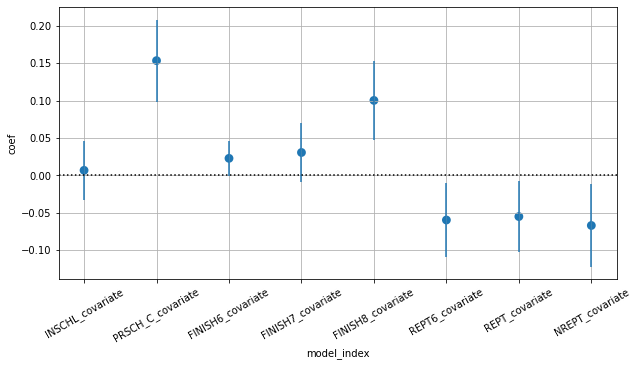

In [28]:
plt.figure(figsize=(10, 5))

ax = sns.pointplot(
    data=models_with_cov_results, 
    x='model_index', 
    y='coef',
    linestyles=''
)

ax.errorbar(
    models_with_cov_results['model_index'], 
    models_with_cov_results['coef'], 
    yerr=models_with_cov_results['std err'].astype(np.float32)*1.96,
    linestyle=''
)

ax.axhline([0], ls=':', color='black')
plt.grid()
plt.xticks(rotation=30)
plt.show()

### 2.3.5 性別による効果差

In [29]:
data_tbl4_bog95 = vouchers[
    (vouchers['BOG95SMP'] == 1) &
    (vouchers['TAB3SMPL'] == 1) &
    (vouchers['SCYFNSH'].isnull() == False) &
    (vouchers['FINISH6'].isnull() == False) &
    (vouchers['PRSCHA_1'].isnull() == False) &
    (vouchers['REPT6'].isnull() == False) &
    (vouchers['NREPT'].isnull() == False) &
    (vouchers['INSCHL'].isnull() == False) &
    (vouchers['FINISH7'].isnull() == False) &
    (vouchers['PRSCH_C'].isnull() == False) &
    (vouchers['FINISH8'].isnull() == False) &
    (vouchers['PRSCHA_2'].isnull() == False) &
    (vouchers['TOTSCYRS'].isnull() == False) &
    (vouchers['REPT'].isnull() == False)
][[
    'VOUCH0', 'SVY', 'HSVISIT', 'DJAMUNDI', 'PHONE', 'AGE', 'STRATA1', 'STRATA2', 'STRATA3', 'STRATA4', 'STRATA5', 'STRATA6', 
    'STRATAMS', 'DBOGOTA', 'D1993', 'D1995', 'D1997', 'DMONTH1', 'DMONTH2', 'DMONTH3', 'DMONTH4', 'DMONTH5', 'DMONTH6', 'DMONTH7', 
    'DMONTH8', 'DMONTH9', 'DMONTH10', 'DMONTH11', 'DMONTH12', 'SEX_MISS', 'FINISH6', 'FINISH7', 'FINISH8', 'REPT6', 'REPT', 'NREPT', 
    'SEX2', 'TOTSCYRS', 'MARRIED', 'HASCHILD', 'HOURSUM', 'WORKING3', 'INSCHL', 'PRSCH_C', 'USNGSCH', 'PRSCHA_1'
]]

data_tbl4_bog95.head(3)

,VOUCH0,SVY,HSVISIT,DJAMUNDI,PHONE,AGE,STRATA1,STRATA2,STRATA3,STRATA4,...,SEX2,TOTSCYRS,MARRIED,HASCHILD,HOURSUM,WORKING3,INSCHL,PRSCH_C,USNGSCH,PRSCHA_1
3,1.0,0.0,0.0,0.0,1.0,14.0,0.0,1.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,1.0,14.0,0.0,1.0,0.0,0.0,...,1.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,1.0,14.0,1.0,0.0,0.0,0.0,...,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [30]:
# 女子生徒のみのデータで回帰分析
regression_data = data_tbl4_bog95[data_tbl4_bog95['SEX2'] == 0]

models_with_cov = {}
for y in formula_y:
    model = smf.ols(formula='{} ~ {} + {}'.format(y, formula_x_base, formula_x_covariate), data=regression_data)
    models_with_cov[y] = model.fit()

In [31]:
df_results_female = get_model_results(models_with_cov, 'covariate')
df_results_female['coef'] = df_results_female['coef'].astype(np.float32)
df_results_female = df_results_female.dropna()
df_results_female

,model_index,coef,std err,t,P>|t|,[0.025,0.975]
0,TOTSCYRS_covariate,0.0909,0.066,1.381,0.168,-0.038,0.220
1,INSCHL_covariate,0.0347,0.028,1.237,0.217,-0.020,0.090
2,PRSCH_C_covariate,0.1711,0.039,4.337,0.000,0.094,0.249
3,USNGSCH_covariate,0.5436,0.032,16.992,0.000,0.481,0.606
4,PRSCHA_1_covariate,0.0229,0.023,1.011,0.312,-0.022,0.067
5,FINISH6_covariate,0.0317,0.014,2.281,0.023,0.004,0.059
6,FINISH7_covariate,0.0411,0.025,1.626,0.105,-0.009,0.091
7,FINISH8_covariate,0.1047,0.037,2.865,0.004,0.033,0.177
8,REPT6_covariate,-0.0362,0.031,-1.155,0.249,-0.098,0.025
9,REPT_covariate,-0.0290,0.032,-0.901,0.368,-0.092,0.034


In [32]:
# 男子生徒のみのデータで回帰分析
regression_data = data_tbl4_bog95[data_tbl4_bog95['SEX2'] == 1]

models_with_cov = {}
for y in formula_y:
    model = smf.ols(formula='{} ~ {} + {}'.format(y, formula_x_base, formula_x_covariate), data=regression_data)
    models_with_cov[y] = model.fit()

In [33]:
df_results_male = get_model_results(models_with_cov, 'covariate')
df_results_male['coef'] = df_results_male['coef'].astype(np.float32)
df_results_male = df_results_male.dropna()
df_results_male

,model_index,coef,std err,t,P>|t|,[0.025,0.975]
0,TOTSCYRS_covariate,-0.0286,0.078,-0.366,0.714,-0.182,0.125
1,INSCHL_covariate,-0.0195,0.030,-0.658,0.511,-0.078,0.039
2,PRSCH_C_covariate,0.1363,0.040,3.433,0.001,0.058,0.214
3,USNGSCH_covariate,0.4677,0.033,14.159,0.000,0.403,0.533
4,PRSCHA_1_covariate,0.0902,0.025,3.555,0.000,0.040,0.140
5,FINISH6_covariate,0.0144,0.020,0.734,0.463,-0.024,0.053
6,FINISH7_covariate,0.0264,0.031,0.866,0.387,-0.034,0.086
7,FINISH8_covariate,0.0950,0.040,2.368,0.018,0.016,0.174
8,REPT6_covariate,-0.0866,0.038,-2.266,0.024,-0.162,-0.012
9,REPT_covariate,-0.0830,0.035,-2.406,0.016,-0.151,-0.015


In [34]:
df_results_male['sex'] = 'male'
df_results_female['sex'] = 'female'

df_results_concat = pd.concat([df_results_male, df_results_female])

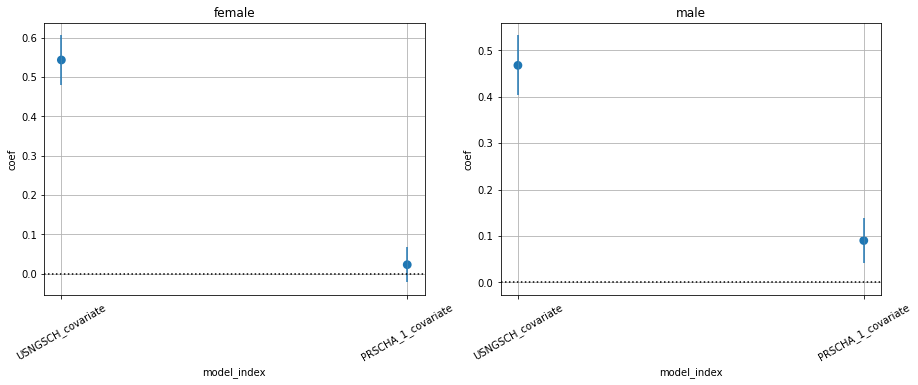

In [35]:
# 私立学校への入学と奨学金の利用
plt.figure(figsize=(15, 5))

for i, df, label in zip([1, 2], [df_results_female, df_results_male], ['female', 'male']):
    plt.subplot(1, 2, i)
    
    ax = sns.pointplot(
        data=df[df['model_index'].isin(['PRSCHA_1_covariate', 'USNGSCH_covariate'])],
        x='model_index', 
        y='coef',
        dodge=True,
        linestyles=''
    )

    ax.errorbar(
        df[df['model_index'].isin(['PRSCHA_1_covariate', 'USNGSCH_covariate'])]['model_index'], 
        df[df['model_index'].isin(['PRSCHA_1_covariate', 'USNGSCH_covariate'])]['coef'], 
        yerr=df[df['model_index'].isin(['PRSCHA_1_covariate', 'USNGSCH_covariate'])]['std err'].astype(np.float32)*1.96,
        linestyle=''
    )

    ax.axhline([0], ls=':', color='black')
    plt.grid()
    plt.title(label)
    plt.xticks(rotation=30)
plt.show()

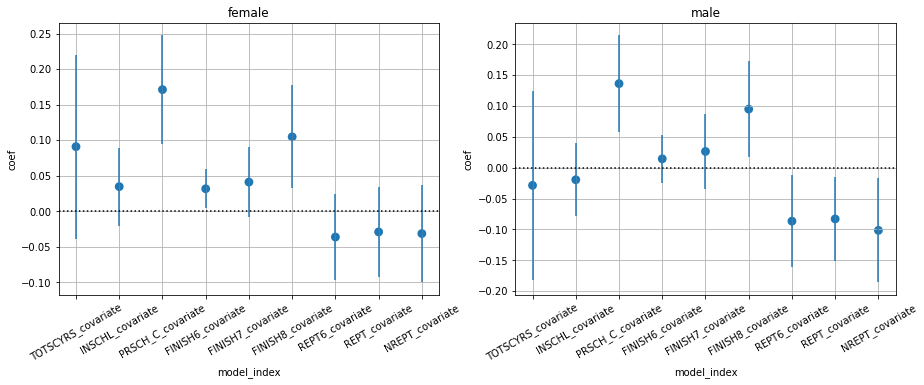

In [36]:
# 留年と進級の傾向
plt.figure(figsize=(15, 5))
display_features = ['FINISH6_covariate', 'FINISH7_covariate', 'FINISH8_covariate', 'INSCHL_covariate', 'NREPT_covariate',
                    'PRSCH_C_covariate', 'REPT_covariate', 'REPT6_covariate', 'TOTSCYRS_covariate']

for i, df, label in zip([1, 2], [df_results_female, df_results_male], ['female', 'male']):
    plt.subplot(1, 2, i)
    
    ax = sns.pointplot(
        data=df[df['model_index'].isin(display_features)],
        x='model_index', 
        y='coef',
        dodge=True,
        linestyles=''
    )

    ax.errorbar(
        df[df['model_index'].isin(display_features)]['model_index'], 
        df[df['model_index'].isin(display_features)]['coef'], 
        yerr=df[df['model_index'].isin(display_features)]['std err'].astype(np.float32)*1.96,
        linestyle=''
    )

    ax.axhline([0], ls=':', color='black')
    plt.grid()
    plt.title(label)
    plt.xticks(rotation=30)
plt.show()

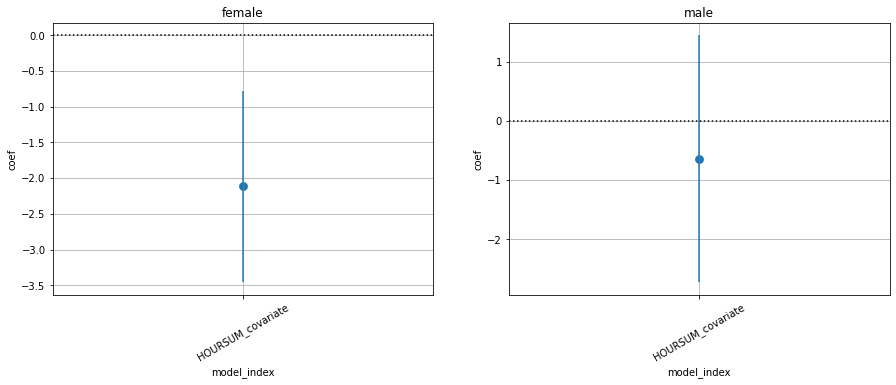

In [37]:
# 労働時間の傾向
plt.figure(figsize=(15, 5))
display_features = ['HOURSUM_covariate']

for i, df, label in zip([1, 2], [df_results_female, df_results_male], ['female', 'male']):
    plt.subplot(1, 2, i)
    
    ax = sns.pointplot(
        data=df[df['model_index'].isin(display_features)],
        x='model_index', 
        y='coef',
        dodge=True,
        linestyles=''
    )

    ax.errorbar(
        df[df['model_index'].isin(display_features)]['model_index'], 
        df[df['model_index'].isin(display_features)]['coef'], 
        yerr=df[df['model_index'].isin(display_features)]['std err'].astype(np.float32)*1.96,
        linestyle=''
    )

    ax.axhline([0], ls=':', color='black')
    plt.grid()
    plt.title(label)
    plt.xticks(rotation=30)
plt.show()